# Huggingface Tutorial

##### 안녕하세요!HuggingFace의 Pretrained Model을 사용하여 영화 감성 분석하는 모델을 시연해볼 수 있는 페이지 입니다! 

허깅페이스에 대한 간략한 설명

Colab GPU사용에 대한 설명

모델을 구현하는데 사용할 데이터는 Hugginface에서 제공하는 IMDB영화 리뷰 데이터를 사용합니다.

해당 코드들은 Colab뿐 아닌 Local환경에서도 실험해볼 수 있습니다.

###### 0. Huggingface Download

데이터와 Pretrained모델 모두 Huggingface를 이용합니다. 이를 위해서는 허깅페이스와 데이터를 Colab에 다운받아야 합니다.

https://huggingface.co/docs/datasets/loading_datasets.html

In [1]:
!pip install transformers

!pip install datasets

###### 1. 데이터 준비

In [2]:
from datasets import load_dataset

datasets=load_dataset('imdb')

Reusing dataset imdb (/home/sammy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


데이터를 사용하기 이전에 어떻게 데이터가 구성되어있는지 확인한 후 어떻게 사용할지 결정합니다.

In [3]:
print(datasets['train'][0])

validation_dataset=datasets["test"]
print(validation_dataset.features)

{'text': 'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!', 'label': 1}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], names_file=None, id=None)}


데이터는 text, label로 구성되어 있음을 확인할 수 있습니다.

data의 세부 구성을 features를 통하여 볼 수 있다. label의 구성이 어떻게 되어있는지 확인 할 수 있음

2. Tokenization

자연어 모델에서의 토큰화는 주어진 코퍼스에서 모델이 사용하기 좋은 형태(token)단위로 나누는 것을 의미합니다. 토큰의 기준과 단위는 각각의 모델마다 다르지만 대부분의 경우 띄어쓰기와 같이 하나의 단어를 기준으로 토큰화를 진행합니다.

Huggingface는 다양한 Pretrained Tokenizer를 제공합니다. 그 중 Bert Model에 사용된 BertTokenizer 'Uncased' model을 사용하였습니다. 'Uncased'란 영어의 대소문자 구분없이 모두 소문자화 시켜 Tokenization하는 모델입니다. Cased 모델은 상대적으로 대문자를 많이 사용하는 Token task들(POS Tagging, NER)에 이점이 있지만 이 이점이 영화 감정 분석에 큰 도움이 되지 못하고 감성 분석에 혼란을 일으키지 않기 위하여 'Uncased'모델을 사용하였습니다.

In [4]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")

tokenized_sentence=tokenizer(validation_dataset[0]['text'])
print(tokenized_sentence)

detokenized_sentence=tokenizer.convert_ids_to_tokens(tokenized_sentence['input_ids'])
print(detokenized_sentence)

{'input_ids': [101, 1045, 2253, 1998, 2387, 2023, 3185, 2197, 2305, 2044, 2108, 28155, 19068, 2000, 2011, 1037, 2261, 2814, 1997, 3067, 1012, 1045, 1005, 2222, 6449, 2008, 1045, 2001, 11542, 2000, 2156, 2009, 2138, 2013, 2054, 1045, 2354, 1997, 13772, 13970, 10649, 2121, 2002, 2001, 2069, 2583, 2000, 2079, 4038, 1012, 1045, 2001, 3308, 1012, 13970, 10649, 2121, 2209, 1996, 2839, 1997, 5180, 13042, 2200, 2092, 1010, 1998, 4901, 3465, 3678, 2209, 3841, 12813, 2007, 2107, 2658, 2964, 1012, 1996, 3696, 1997, 1037, 2204, 3185, 2003, 2008, 2009, 2064, 9121, 2007, 2256, 6699, 1012, 2023, 2028, 2106, 3599, 2008, 1012, 1996, 2972, 4258, 1006, 2029, 2001, 2853, 2041, 1007, 2001, 9462, 2011, 7239, 2076, 1996, 2034, 2431, 1997, 1996, 3185, 1010, 1998, 2020, 2333, 2000, 4000, 2076, 1996, 2117, 2431, 1012, 2096, 22371, 1996, 4258, 1045, 2025, 2069, 2387, 2116, 2308, 1999, 4000, 1010, 2021, 2116, 2440, 4961, 2273, 2004, 2092, 1010, 2667, 9652, 2025, 2000, 2292, 3087, 2156, 2068, 6933, 1012, 2023, 318

하나의 데이터에 한해서 진행하던 Tokenization을 전체 데이터 셋에 적용합니다.
이를 위해서 Tokenization 함수를 하나 생성합니다.
사용하는 Pretrained BERT모델은 512이상의 문장은 입력받을 수 없습니다.
Batch size는 설정하지 않는다면 Default 값인 1000으로 설정됩니다.
Tokenizer의 매개변수들의 쓰임새는 다음과 같습니다.
Padding=True => Batch size내의 가장 긴 문장을 기준으로 다른 모든 문장들을 Padding합니다.
https://huggingface.co/transformers/internal/tokenization_utils.html#transformers.tokenization_utils_base.PreTrainedTokenizerBase

Tokenization을 마친 데이터는 'Attention_mask','input_ids','token_type_ids','text','label'의 Key값을 가진 Dictionary형태를 갖습니다.

In [5]:
def tokenization(sentence):
    return tokenizer(sentence["text"], padding=True, truncation=True)# 길이를 512로 맞추기 위한 옵션들

print("fuction test")
tokenization_function=datasets.map(tokenization,batched=True)
print(tokenization_function["train"])

Loading cached processed dataset at /home/sammy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-763ead1dae8f19d0.arrow


fuction test


Loading cached processed dataset at /home/sammy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-2112260d49d7798d.arrow
Loading cached processed dataset at /home/sammy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-4475679125e73f9f.arrow


Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
    num_rows: 25000
})


In [6]:
print(tokenization_function["train"][0])

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

모델을 학습시킬 때 Batchsize에 따라 분할하여 학습시킨다면 Batch안의 모든 데이터의 길이는 하나로 통일되어야 합니다. 
이를 위하여 Datacollator를 사용하여 batch안의 데이터들의 길이를 일정하게 세팅합니다.
Datacollator는 데이터 중 가장 긴 문장을 기준으로 나머지 문장들을 Padding합니다.

In [7]:
from transformers import DataCollatorWithPadding
Data_collator=DataCollatorWithPadding(tokenizer=tokenizer)

DataCollation가 어떻게 구현되는지 확인할 수 있는 예제입니다.

In [8]:
sample=tokenization_function["train"][:8]
sample={k: v for k, v in sample.items() if k not in ['text','token_type_ids']}
padding=Data_collator(sample)
print({k: v.shape for k, v in padding.items()})

for i in sample.keys():
    print(sample[i][0])

{'attention_mask': torch.Size([8, 512]), 'input_ids': torch.Size([8, 512]), 'labels': torch.Size([8])}
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Data에서 필요없는 Columns은 제거하고 데이터의 유형을 torch로 변환하여줍니다..
현 데이터에서는 하나의 문장이 한 Sequence별로 들어가기에 Token_type_ids는 필요하지 않습니다.
token_type_ids는 두개 이상의 문장이 하나의 Sequence에 학습되어 요소들을 구분할 때 필요한 Columns입니다.
'text' 또한 모델의 학습 측면에서는 의미가 없는 데이터임으로 제거하여줍니다.

데이터의 Format 또한 torch로 변경하여줍니다.

In [9]:
tokenization_function=tokenization_function.remove_columns(['text','token_type_ids'])
tokenization_function.set_format("torch")

In [18]:
from torch.utils.data import DataLoader

train_data=DataLoader(tokenization_function['train'],batch_size=5,shuffle=True, collate_fn=Data_collator)
test_data=DataLoader(tokenization_function['test'],batch_size=10,shuffle=True, collate_fn=Data_collator)

In [19]:
#데이터 확인
for batch in train_data:
    break
print({k: v.shape for k, v in batch.items()})

{'attention_mask': torch.Size([5, 512]), 'input_ids': torch.Size([5, 512]), 'labels': torch.Size([5])}


###### 3. Model

사전학습된 Pretrained 'bert-base-uncased'모델은 영화 감성 분석에 적합한 모델이 아니기에 사용하려는 목적에 맞게 Fine-tuning하는 작업이 필요합니다. 

학습시에 모델의 Memory문제가 발생한다면 Batch_size를 조절해가며 각 하드웨어에 적합한 Batch_size로 학습해보시길 바랍니다.

In [20]:
from transformers import BertForSequenceClassification

model=BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [21]:
import torch
output=model(**batch)

print(output.loss,output.logits.shape)
print(torch.argmax(output.logits,dim=-1))

tensor(0.6683, grad_fn=<NllLossBackward>) torch.Size([5, 2])
tensor([0, 1, 0, 0, 0])


###### 3.1 Optimizer

Adafactor는 Adam Optimizer를 기반으로한 Adaptive한 Optimizer입니다. 
Learning rate값은 1e-3으로 설정하였습니다. 모델의 Learning rate는 학습에 매우 큰 영향을 미칩니다. 모델의 Learning rate를 변경하였을때 변화하는 모델의 성능을 비교해보세요^^.

Adafactor Optimizer 관련 논문: https://arxiv.org/abs/1804.04235

In [22]:
from transformers import Adafactor

optimizer=Adafactor(model.parameters(),relative_step=False, lr=1e-3)

In [23]:
epoch=3
total_step=len(train_data)*epoch
from transformers import get_scheduler
scheduler=get_scheduler('linear',optimizer,num_training_steps=total_step,num_warmup_steps=100)

CPU혹은 GPU 중 GPU가 존재한다면 GPU를 이용하도록 유도하는 코드입니다.
Pytorch에서는 GPU나 CPU를 사용할때 해당 Device로 데이터를 넘겨줘야합니다. GPU를 사용한다면 데이터들을 이동시켜주는 작업을   
model.to(device)   
코드를 통해 실행합니다.

In [26]:
#GPU를 설정하기도 하며 없다면 CPU를 사용하는 device로 설정하는 코드
import torch

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

True


RuntimeError: CUDA out of memory. Tried to allocate 90.00 MiB (GPU 0; 3.94 GiB total capacity; 2.30 GiB already allocated; 18.44 MiB free; 2.35 GiB reserved in total by PyTorch)

###### 4. Training

이전의 섹션 3에서 설정한 요소들을 하나의 모델로 구성하여 학습시키는 단계입니다.
가장 중요한 것은 순서가 정확하게 이루어져야 모델의 학습이 올바르게 이루어질 수 있습니다.
모델이 하나의 batch에 학습을 마치면 이루어진 학습에 대해서 optimizer와 Backpropagation을 통하여 Learning rate와 가중치값을 조절하며 학습할 수 있도록 모델을 유도합니다. 해당 Task가 끝나면 Zero_grad로 초기화 시켜줍니다.

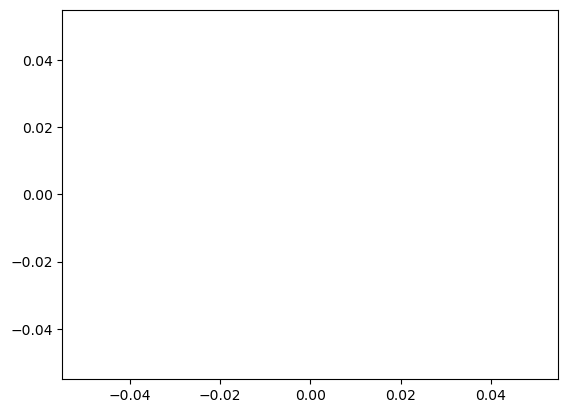

In [27]:
from tqdm.auto import tqdm
import torchmetrics

progress_bar = tqdm(range(total_step))

from datasets import load_metric
import matplotlib.pyplot as plt

plt_loss=[]

for epoch in range(epoch):    
    for i, batch in enumerate(train_data):
        model.train()
        batch = {k: v.to(device) for k, v in batch.items()}
        output=model(**batch)
        loss=output.loss
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        if i%300==0:
            model.eval()
            with torch.no_grad():
                metric=load_metric('glue','sst2')
                for valid_data in validation_data:
#                     add_batch메서드로 인하여 사용하지 않아도 됨
#                     if i//1000==p:
                    valid={k:v.to(device) for k, v in valid_data.items()}
                    valid_output=model(**valid)
                    valid_loss=valid_output.loss
                    #logits와 이를 argmax취해주지 않으면 
                    logits = valid_output.logits
                    predictions = torch.argmax(logits, dim=-1)
                    metric.add_batch(predictions=predictions, references=valid['labels'])
                valid_acc=metric.compute()
                plt_loss.append(valid_loss)
            print(valid_acc)
            print(output.loss)
            prediction=output.logits
            prediction=torch.argmax(prediction,dim=1)
            print(prediction,batch['labels'])
            
loss_plot=[]
for i in range(len(plt_loss)):
    b=plt_loss[i].cpu()
    loss_plot.append(b)

plt.plot(list(range(len(loss_plot))),loss_plot)
plt.show()
        
#CUDA memory문제가 있을 때에는 재시동을 해볼 것

Colab기준으로 3:53:11시간이 학습을 하는데 소요되었습니다.
다음은 학습을 마친 모델을 저장합니다

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cd gdrive/MyDrive/Colab\ Notebooks

torch.save(model,'model_learning_rate_2e-5.pt')

모델에 대한 학습이 끝났다면 문장을 직접 생성하며 모델을 이용한 감성 분석을 실제로 구해봅니다.

In [ ]:
def persona_analysis(sentence):
    emotion={0:'부정',1:'긍정'}.get(sentence,"알 수 없음")
    return emotion

In [ ]:
def predict(predict_sentence):

    text=predict_sentence

    text=tokenizer(text,return_tensors='pt')
    del(text['token_type_ids'])
    text.to(device)
    model.eval()
    
    output=model(**text)
    loss=output.loss
    predict=torch.argmax(output.logits)
    predict=persona_analysis(int(predict))

    print(">> 입력하신 내용에서 " + predict + " 느껴집니다.")

In [ ]:
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")